# Matching

## Описание проекта

<b>Matching</b> - это задача поиска и сопоставления двух объектов из разных наборов данных. Такая потребность возникла у маркетплейса, который имеет большой перечен товаров для продажи. На склад стали поступать новые партии товаров, которые имеет небольшие отличия в характеристиках. Технически, это выглядит как совершенно новые товары. Фактически это те же товары, которые уже продаются на маркетплейсе. Задача сопоставить и связать новые товары со старыми, пользуясь совпадающими характеристиками.

<b>Что надо сделать?</b>

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.

### Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import faiss
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csc_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN,AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import calinski_harabasz_score

/var/folders/x7/q4sdzlx52qxcx1hck0271d8c0000gn/T/ipykernel_14208/1475496292.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_train = pd.read_csv('train.csv')
df_base = pd.read_csv('base.csv')
df_validation = pd.read_csv('validation.csv')
df_validation_answer = pd.read_csv('validation_answer.csv')

In [3]:
df_base.duplicated().sum()

0

<b>Уменьшим выборку датасета</b>

In [4]:
df_base_sample = df_base.sample(100000)

<b>Создадим диаграмму кластера</b>

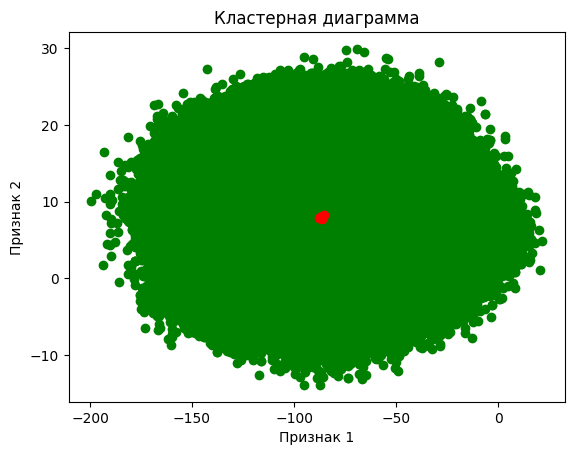

In [5]:
features = df_base.iloc[:, 1:]

kmeans = KMeans(n_clusters=5)
kmeans.fit(features)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c='green')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='red', label='Центроиды')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Кластерная диаграмма')
plt.show()

<b>Выбор оптимального числа кластеров</b>

In [6]:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(df_base.iloc[:, 1:])

# wcss = []
# for i in range(1, 51):
#     kmeans = KMeans(n_clusters=i, random_state=0)
#     kmeans.fit(scaled_data)
#     wcss.append(kmeans.inertia_)

# plt.plot(range(1, 75), wcss)
# plt.title('Метод локтя')
# plt.xlabel('Количество кластеров')
# plt.ylabel('Сумма квадратов расстояний')
# plt.show()

<b>Рассчеты со скалированием данных</b>

In [7]:
base_features = df_base.iloc[:, 1:]
train_features = df_train.iloc[:, 1:-1]
validation_features = df_validation.iloc[:, 1:]

base_sample_features = base_features.sample(n=200000, replace=True, random_state=42)

scaler = RobustScaler()
base_sample_features_scaled = scaler.fit_transform(base_sample_features)
train_features_scaled = scaler.transform(train_features)
validation_features_scaled = scaler.transform(validation_features)

In [8]:
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=72)),
    ('knn', NearestNeighbors(n_neighbors=5)),
])

pipeline.fit(base_sample_features_scaled)

cluster_centers = pipeline.named_steps['kmeans'].cluster_centers_
distances, indices = pipeline.named_steps['knn'].kneighbors(train_features_scaled)
validation_distances, validation_indices = pipeline.named_steps['knn'].kneighbors(validation_features_scaled)

In [9]:
def calculate_accuracy(indices, validation_indices):
    correct_count = 0
    for i in range(len(indices)):
        if set(validation_indices[i]).intersection(set(indices[i])):  # Проверяем, есть ли общие элементы
            correct_count += 1
    accuracy = (correct_count / (5 * len(validation_indices))) * 100
    return accuracy

accuracy_5 = calculate_accuracy(indices, validation_indices)

In [10]:
def accuracy_n(targets, predict, base_index=base_index):
    acc = 0
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        acc += int(target in [base_index[number] for number in candidates])

    return (acc / len(predict) * 100)

print('accuracy@{}: {:.2f}%'.format(5, accuracy_n(indices, validation_indices)))

NameError: name 'base_index' is not defined

In [ ]:
print("Значение метрики accuracy@5 для validation.csv:")
print(accuracy_5)

In [ ]:
df_sample = df_base.sample(100000)
df_sample.head()

<b>Подключим faiss</b>

In [ ]:
base_sample_features_np = np.array(base_sample_features_scaled).astype('float32')
train_features_np = np.array(train_features_scaled).astype('float32')
validation_features_np = np.array(validation_features_scaled).astype('float32')

In [ ]:
index = faiss.IndexFlatL2(base_sample_features_np.shape[1])

index.add(base_sample_features_np)

D, I = index.search(train_features_np, 5)
D_val, I_val = index.search(validation_features_np, 5)

index = faiss.IndexFlatIP(base_sample_features_np.shape[1])
index.add(base_sample_features_np)
D_ip, I_ip = index.search(train_features_np, 5)
D_val_ip, I_val_ip = index.search(validation_features_np, 5)

In [ ]:
accuracy_5_l2 = calculate_accuracy(I, I_val)
accuracy_5_ip = calculate_accuracy(I_ip, I_val_ip)

print("L2 accuracy@5 for validation.csv:", accuracy_5_l2)
print("Inner product accuracy@5 for validation.csv:", accuracy_5_ip)

In [ ]:
for n_clusters in [5, 10, 20, 50, 100]:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(base_sample_features_scaled)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(base_sample_features_scaled, labels)
    davies_bouldin = davies_bouldin_score(base_sample_features_scaled, labels)
    calinski_harabasz = calinski_harabasz_score(base_sample_features_scaled, labels)
    print(f"For n_clusters = {n_clusters}, silhouette score is {silhouette_avg}, davies bouldin score is {davies_bouldin}, calinski harabasz score is {calinski_harabasz}")

print("Number of indexes in FAISS:", index.ntotal)

In [ ]:
knn = NearestNeighbors(n_neighbors=5)
knn.fit(base_sample_features_scaled)
distances_knn, indices_knn = knn.kneighbors(train_features_scaled)
validation_distances_knn, validation_indices_knn = knn.kneighbors(validation_features_scaled)
accuracy_5_knn = calculate_accuracy(indices_knn, validation_indices_knn)

In [ ]:
kmeans = AgglomerativeClustering(n_clusters=72)

kmeans.fit(base_sample_features_scaled)
labels = kmeans.predict(train_features_scaled)
silhouette_avg_kmeans = silhouette_score(train_features_scaled, labels)
davies_bouldin_kmeans = davies_bouldin_score(train_features_scaled, labels)
calinski_harabasz_kmeans = calinski_harabasz_score(train_features_scaled, labels)

print("KNN accuracy@5 for validation.csv:", accuracy_5_knn)
print(f"For KMEANS, silhouette score is {silhouette_avg_kmeans}, davies bouldin score is {davies_bouldin_kmeans}, calinski harabasz score is {calinski_harabasz_kmeans}")


In [ ]:
results = pd.DataFrame({
    'Method': ['FAISS L2', 'FAISS IP', 'KNN', 'KMEANS'],
    'Accuracy@5': [accuracy_5_l2, accuracy_5_ip, accuracy_5_knn, None],
    'Silhouette Score': [None, None, None, silhouette_avg_kmeans],
    'Davies Bouldin Score': [None, None, None, davies_bouldin_kmeans],
    'Calinski Harabasz Score': [None, None, None, calinski_harabasz_kmeans]
})

print(results)